## Image Denoise
In this notebook, we present an image denoise experiment where FCA performs better than ICA.
(This simulation is associated with Figure 4 and Figure 8 in FCA paper.)

In [75]:
push!(LOAD_PATH, "../../src")
using FCA
using Colors, Images, FileIO, Plots, Statistics, LinearAlgebra

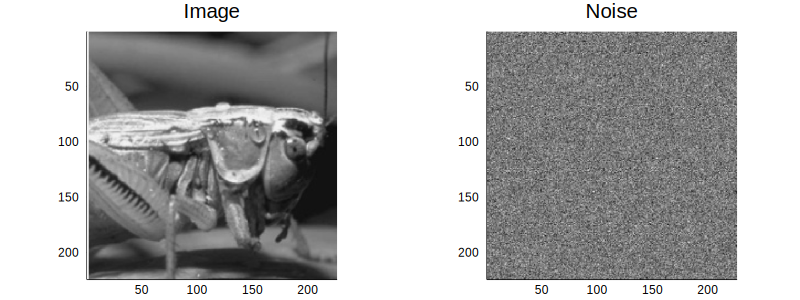

In [85]:
# import the panda image
image = "../images/locust.jpg"; # also try images/locust.jpg
I1 = Float64.(Gray.(load(image)))

# generate the white noise, match the variance
I2 = randn(size(I1))*std(I1)

# plot the original image and noise
p1 = heatmap(I1, yflip=true, color=:grays, aspect_ratio=:equal, title="Image", colorbar = false)
p2 = heatmap(I2, yflip=true, color=:grays, aspect_ratio=:equal, title="Noise", colorbar = false)
plot(p1, p2; size=(800, 300))

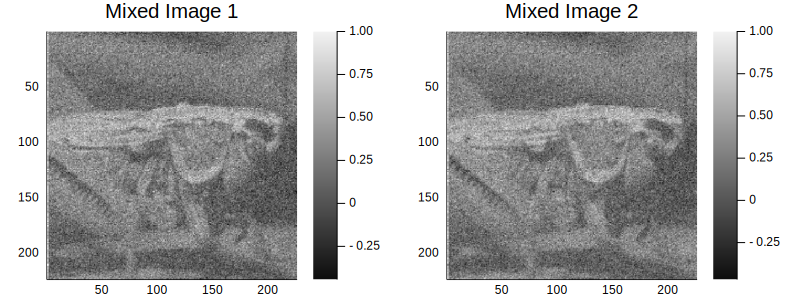

In [86]:
# Noise image
X = [I1, I2]
I1 = 0.0
I2 = 0.0 ## this clears I1 and I2 from memory

# mixing matrix
A = [1 1; 1 -1]/sqrt(2);
Z = A*X

# normalize the mixed images for plot
mixed1 = Z[1]/maximum(Z[1])
mixed2 = Z[2]/maximum(Z[2])

# plot the mixed images
p3 = heatmap(mixed1, yflip=true, color=:grays, aspect_ratio=:equal, title="Mixed Image 1")
p4 = heatmap(mixed2, yflip=true, color=:grays, aspect_ratio=:equal, title="Mixed Image 2")

# release the memory
mixed1, mixed2 = 0.0, 0.0

# show the plot
plot(p3, p4; size=(800, 300))

## Denoise image using icf

In [87]:
# using icf to denoise image
# reshape mixed images to vector
z = [vec(Z[i]) for i = 1: 2]

# apply icf
Aica, xica = icf(z)

([-0.196949 -0.112648; -0.112926 0.196606], Array{Float64,1}[[-4.06736, -4.01634, -4.81887, -4.07056, -4.38784, -4.57629, -4.52071, -4.23294, -4.17653, -4.34547  …  -2.31203, -1.81868, -2.29573, -1.66233, -1.98836, -1.68537, -1.50433, -1.03337, -1.51004, -1.28931], [1.83235, 2.02067, -0.941351, 1.82055, 0.649503, -0.112074, 0.159136, 1.22121, 1.42945, 0.805908  …  0.0539628, 1.41243, -0.61247, 1.32894, -0.204632, 0.715476, 1.11943, 2.19709, -0.288832, -0.00259209]])

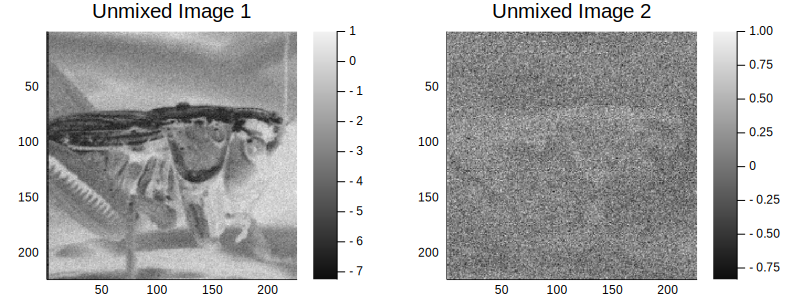

In [88]:
# normalize the unmixed images
unmixed1ica = reshape(xica[1]/maximum(xica[1]), size(Z[1]))
unmixed2ica = reshape(xica[2]/maximum(xica[2]), size(Z[1]))

# Plot the denoised image by icf, note that there is still some noise left.
p5 = heatmap(unmixed1ica, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p6 = heatmap(unmixed2ica, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")
plot(p5, p6; layout=2, size=(800, 300))

  0.993009 seconds (426.08 k allocations: 445.477 MiB, 11.27% gc time)


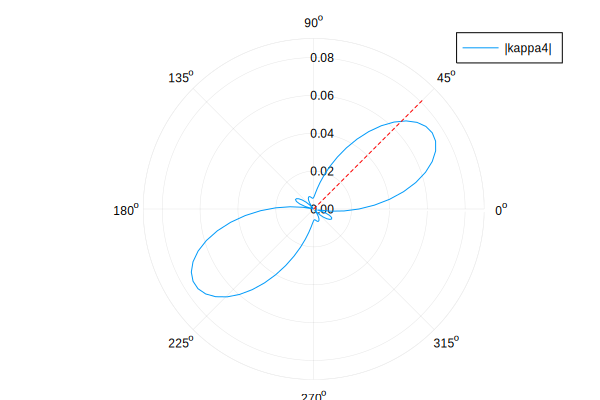

In [89]:
# the direction found by maximize sum of absolute value of kurtosis
# does not recover the independent component

# whiten the original images sepearately 
x = [vec(X[1]), vec(X[2])]
x = [(x[i] .- mean(x[i]))/std(x[i]) for i = 1: 2]

z = A*x
# plot the sum of absolute value of kurtosis vs theta
θ_range = range(0, stop = 2π, length = 100)
@time plot(θ -> -neg_abs_sum_kurt([cos(θ) sin(θ)]*z), 
    θ_range, proj=:polar, label="|kappa4|")
y1, y2 = ylims()
plot!([0, pi/4], [y1, y2], seriestype=:path, proj=:polar, color=:red, label = "", linestyle = :dash,)

## Denoise image using fcf

  2.048672 seconds (3.38 k allocations: 703.636 MiB, 5.58% gc time)


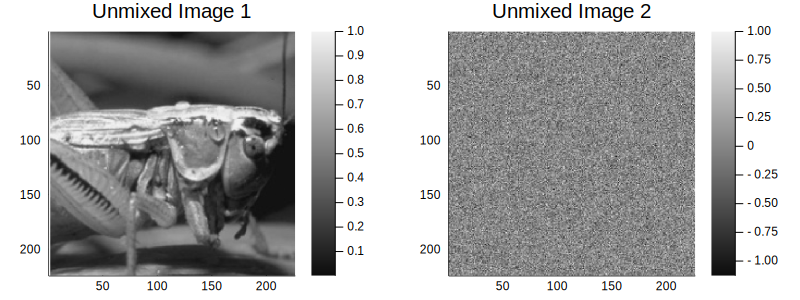

In [90]:
# Apply kurtosis-based freecf to unmix the images
@time Afca, Xfca = freecf(Z; mat = "rec")
 
# normalized the unmixed images 
unmixed1fca = Xfca[1]/maximum(Xfca[1])
unmixed2fca = Xfca[2]/maximum(Xfca[2])

# plot the unmixed images
p7 = heatmap(unmixed1fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p8 = heatmap(unmixed2fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")

unmixed1fca = 0.0
unmixed2fca = 0.0

# show the unmixed images, compare it with icf result
plot(p7, p8; layout=2, size=(800, 300))

  7.408539 seconds (27.13 M allocations: 2.159 GiB, 9.79% gc time)


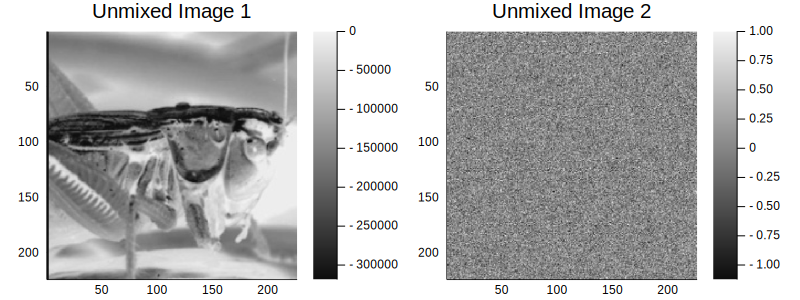

In [92]:
# Apply entropy-based freecf to unmix the images
@time Afca, Xfca = freecf(Z; mat = "rec", obj = "ent")
 
# normalized the unmixed images 
unmixed1fca = Xfca[1]/maximum(Xfca[1])
unmixed2fca = Xfca[2]/maximum(Xfca[2])

# plot the unmixed images
p9 = heatmap(unmixed1fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p10 = heatmap(unmixed2fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")

unmixed1fca = 0.0
unmixed2fca = 0.0

# show the unmixed images, compare it with icf result
plot(p9, p10; layout=2, size=(800, 300))

  0.700216 seconds (425.87 k allocations: 444.447 MiB, 11.56% gc time)


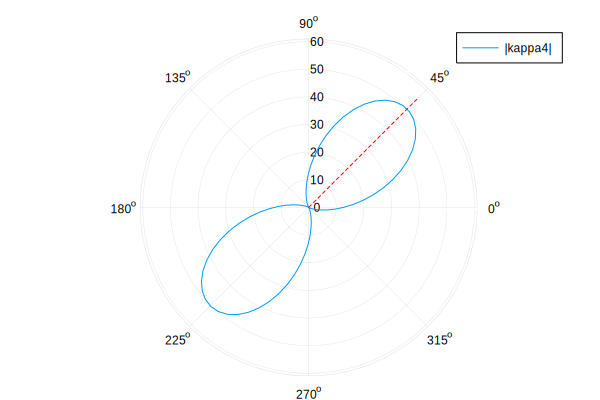

In [67]:
# the direction found by maximize sum of absolute value of free kurtosis
# does recover the independent component

# whiten the original images sepearately 
X = [free_whiten([Xi]; mat = "rec")[1][1] for Xi in X]

Z = A*X
# plot the sum of absolute value of kurtosis vs theta
θ_range = range(0, stop = 2π, length = 100)
@time plot(θ -> -neg_abs_sum_free_kurt([cos(θ) sin(θ)]*Z), 
    θ_range, proj=:polar, label="|kappa4|")
y1, y2 = ylims()
plot!([0, pi/4], [y1, y2], seriestype=:path, proj=:polar, color=:red, label = "", linestyle = :dash)

  6.688137 seconds (40.60 M allocations: 2.598 GiB, 10.57% gc time)


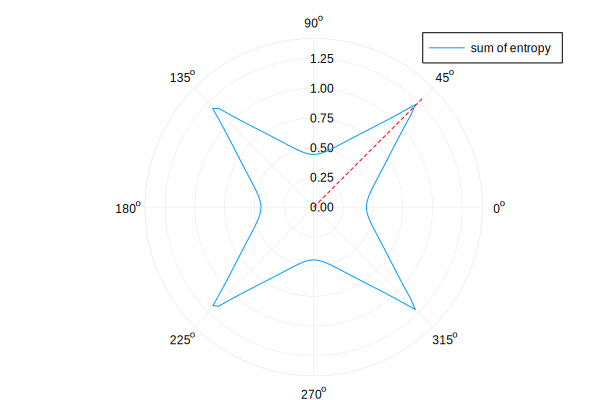

In [104]:
# the direction found by maximize sum of absolute value of free kurtosis
# does recover the independent component

# whiten the original images sepearately 
X = [free_whiten([Xi]; mat = "rec")[1][1] for Xi in X]

Z = A*X
# plot the sum of absolute value of kurtosis vs theta
θ_range = range(0, stop = 2π, length = 200)
@time plot(θ -> -sum_free_ent([cos(θ) sin(θ); -sin(θ) cos(θ)]*Z; mat = "rec"), 
    θ_range, proj=:polar, label="sum of entropy")
y1, y2 = ylims()
plot!([0, pi/4], [y1, y2], seriestype=:path, proj=:polar, color=:red, label = "", linestyle = :dash)